# EWGM Ensemble: Weight Decay + Seasonality + POI

### Score: 0.54403

Ensemble of three EWGM variants to capture declining market trends and seasonal patterns:
- **Baseline (40%)**: POI-enhanced EWGM with standard exponential weighting
- **Weight Decay (30%)**: Additional temporal decay to capture recent downward trends more aggressively  
- **12-Month Seasonality (30%)**: Month-specific predictions using only same-month historical data

Includes correlation check against proven baseline (0.56569) to validate ensemble stability.

In [ ]:
import pandas as pd
import numpy as np
from functools import partial

# =====================================================
# CONFIGURATION - Adjust these parameters to experiment
# =====================================================

CONFIG = {
    # Core EWGM parameters
    'n_lags': 6,           # Number of historical months to use
    'alpha': 0.5,          # Exponential decay rate (0-1, higher = more recent weight)
    't2': 6,               # Minimum non-zero values required
    
    # December multiplier bounds
    'clip_low': 1.0,      # Minimum December multiplier
    'clip_high': 1.8,      # Maximum December multiplier
    
    # POI enhancement
    'poi_weight': 0,     # POI feature weight (0 = disabled)
    
    # Ensemble weights (must sum to 1.0)
    'weight_baseline': 0,    # Weight for POI-enhanced baseline
    'weight_decay': 0.3,       # Weight for weight decay model
    'weight_seasonal': 0.6,    # Weight for seasonality model
    
    # Weight decay parameter
    'decay': 0.95,         # Additional temporal decay (0-1, lower = more aggressive)
    
    # Seasonality parameter
    'seasonal_alpha': 0.7, # Decay for same-month historical values
    
    # Paths
    'data_path': '/Users/nikola/Python/KaggleCompetition/data',
    'output_path': '/Users/nikola/Python/KaggleCompetition/output/13_ENSEMBLE_EWGM'
}

# =====================================================
# Utility Functions
# =====================================================

def build_month_codes():
    """Create a mapping from month abbreviations to numeric values."""
    return {m: i for i, m in enumerate(
        ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], start=1)}


def split_test_id_column(df: pd.DataFrame) -> pd.DataFrame:
    """Parse the ID column into month text and sector components."""
    parts = df['id'].str.split('_', expand=True)
    df['month_text'], df['sector'] = parts[0], parts[1]
    return df


def add_time_and_sector_fields(df: pd.DataFrame, month_codes: dict) -> pd.DataFrame:
    """Add parsed year, month, time index, and sector_id to dataframe."""
    if 'sector' in df.columns:
        df['sector_id'] = df['sector'].str[7:].astype(int)

    if 'month' in df.columns:  # test data
        df['year'] = df['month'].str[:4].astype(int)
        df['month'] = df['month'].str[5:].map(month_codes)
    else:  # train data
        df['year'] = df['month_text'].str[:4].astype(int)
        df['month'] = df['month_text'].str[5:].map(month_codes)

    df['time'] = (df['year'] - 2019) * 12 + df['month'] - 1
    return df


def load_competition_data_with_poi():
    """Load competition data including POI features."""
    path = CONFIG['data_path']
    train = pd.read_csv(f'{path}/train/new_house_transactions.csv')
    test = pd.read_csv(f'{path}/test.csv')
    poi = pd.read_csv(f'{path}/train/sector_poi.csv')
    return train, test, poi


# =====================================================
# Data Transformation
# =====================================================

def build_amount_matrix_with_poi(train: pd.DataFrame, poi: pd.DataFrame, month_codes: dict):
    """Build transaction matrix and POI features."""
    from sklearn.preprocessing import StandardScaler
    
    # Build transaction matrix
    train = add_time_and_sector_fields(train.copy(), month_codes)
    pivot = train.pivot_table(
        index='time', columns='sector_id',
        values='amount_new_house_transactions', fill_value=0
    )
    
    all_sectors = np.arange(1, 97)
    pivot = pivot.reindex(columns=all_sectors, fill_value=0)
    
    # Prepare POI features
    poi_cols = ['office_population', 'education', 'surrounding_housing_average_price', 
                'medical_health', 'subway_station_cnt']
    
    poi['sector_id'] = poi['sector'].str.extract(r'(\d+)').astype(int)
    poi_features = poi[['sector_id'] + poi_cols].set_index('sector_id')
    
    # Normalize POI features
    scaler = StandardScaler()
    poi_features[poi_cols] = scaler.fit_transform(poi_features[poi_cols])
    poi_features = poi_features.reindex(all_sectors, fill_value=0)
    
    return pivot, poi_features

# =====================================================
# Modeling Helpers
# =====================================================

def compute_december_multipliers(a_tr, eps=1e-9, min_dec_obs=1, clip_low=1.0, clip_high=1.5):
    """Compute sector-level December multipliers - ALWAYS >= 1.0 for spike."""
    is_dec = (a_tr.index % 12 == 11)
    dec_means = a_tr[is_dec].mean()
    nondec_means = a_tr[~is_dec].mean()
    dec_counts = a_tr[is_dec].count()

    raw_mult = dec_means / (nondec_means + eps)
    overall_mult = float(dec_means.mean() / (nondec_means.mean() + eps))

    raw_mult = raw_mult.where(dec_counts >= min_dec_obs, overall_mult)
    raw_mult = raw_mult.replace([np.inf, -np.inf], 1.0).fillna(1.0)
    
    # FORCE: clip_low now starts at 1.0, ensuring spike not drop
    return raw_mult.clip(clip_low, clip_high).to_dict()

def apply_december_bump_row(pred_row: pd.Series, sector_to_mult: dict) -> pd.Series:
    """Apply December adjustment to a prediction row."""
    return pred_row.multiply(pd.Series(sector_to_mult)).fillna(pred_row)


def ewgm_per_sector(a_tr, sector, n_lags, alpha):
    """Exponential weighted geometric mean for one sector."""
    recent = a_tr[sector].tail(n_lags).values
    if len(recent) < n_lags or (recent <= 0).all():
        return 0.0

    weights = np.array([alpha**(n_lags - 1 - i) for i in range(n_lags)])
    weights /= weights.sum()

    mask = recent > 0
    if not mask.any():
        return 0.0

    log_vals = np.log(recent[mask] + 1e-12)
    pos_w = weights[mask] / weights[mask].sum()
    return float(np.exp(np.sum(pos_w * log_vals)))


# =====================================================
# NEW: Weight Decay Variant
# =====================================================

def ewgm_with_weight_decay(a_tr, sector, n_lags, alpha, decay):
    """
    EWGM with additional weight decay - older data gets exponentially less weight.
    This captures declining trends more aggressively.
    """
    recent = a_tr[sector].tail(n_lags).values
    if len(recent) < n_lags or (recent <= 0).all():
        return 0.0

    # Apply both alpha decay and additional time decay
    weights = np.array([alpha**(n_lags - 1 - i) * decay**i for i in range(n_lags)])
    weights /= weights.sum()

    mask = recent > 0
    if not mask.any():
        return 0.0

    log_vals = np.log(recent[mask] + 1e-12)
    pos_w = weights[mask] / weights[mask].sum()
    return float(np.exp(np.sum(pos_w * log_vals)))


# =====================================================
# NEW: 12-Month Seasonality Variant
# =====================================================

def ewgm_with_seasonality(a_tr, sector, target_time):
    """
    EWGM using only same-month historical data (12-month seasonality).
    E.g., to predict August, use only past Augusts.
    """
    # Get month-of-year for target
    month_of_year = target_time % 12
    
    # Get all historical data for this month-of-year
    same_month_mask = (a_tr.index % 12) == month_of_year
    historical_same_month = a_tr[same_month_mask][sector]
    
    if len(historical_same_month) == 0 or (historical_same_month <= 0).all():
        return 0.0
    
    # Weight recent years more heavily using config
    seasonal_alpha = CONFIG['seasonal_alpha']
    n = len(historical_same_month)
    weights = np.array([seasonal_alpha**(n - 1 - i) for i in range(n)])
    weights /= weights.sum()
    
    values = historical_same_month.values
    mask = values > 0
    if not mask.any():
        return 0.0
    
    log_vals = np.log(values[mask] + 1e-12)
    pos_w = weights[mask] / weights[mask].sum()
    return float(np.exp(np.sum(pos_w * log_vals)))


def ewgm_per_sector_with_poi(a_tr, poi_features, sector, n_lags, alpha, poi_weight=0.1):
    """Enhanced EWGM with POI adjustment."""
    base_pred = ewgm_per_sector(a_tr, sector, n_lags, alpha)
    if base_pred == 0:
        return 0.0
    
    poi_score = poi_features.loc[sector].sum()
    poi_multiplier = 1.0 + (poi_score * poi_weight)
    poi_multiplier = np.clip(poi_multiplier, 0.7, 1.3)
    
    return base_pred * poi_multiplier


# =====================================================
# NEW: Ensemble Prediction
# =====================================================

def predict_horizon_ensemble(a_tr, poi_features, n_lags, alpha, t2, poi_weight, 
                             weight_baseline, weight_decay_model, weight_seasonal, decay):
    """
    Ensemble of three EWGM variants with December multiplier applied to each component.
    1. Baseline POI-enhanced EWGM (or basic EWGM if poi_weight=0)
    2. Weight decay EWGM
    3. Seasonality EWGM
    """
    idx = np.arange(67, 79)
    preds = pd.DataFrame(index=idx, columns=a_tr.columns, dtype=float)
    
    # Calculate December multipliers once
    mult = compute_december_multipliers(a_tr, clip_low=CONFIG['clip_low'], clip_high=CONFIG['clip_high'])
    
    for target_time in idx:
        is_december = (target_time % 12 == 11)
        
        for sector in a_tr.columns:
            if (a_tr[sector].tail(t2).min() == 0) or (a_tr[sector].sum() == 0):
                preds.loc[target_time, sector] = 0.0
            else:
                # Model 1: Baseline (POI-enhanced or basic depending on poi_weight)
                if poi_weight > 0:
                    pred1 = ewgm_per_sector_with_poi(a_tr, poi_features, sector, n_lags, alpha, poi_weight)
                else:
                    pred1 = ewgm_per_sector(a_tr, sector, n_lags, alpha)
                if is_december:
                    pred1 *= mult.get(sector, 1.0)
                
                # Model 2: Weight decay
                pred2 = ewgm_with_weight_decay(a_tr, sector, n_lags, alpha, decay)
                if is_december:
                    pred2 *= mult.get(sector, 1.0)
                
                # Model 3: Seasonality
                pred3 = ewgm_with_seasonality(a_tr, sector, target_time)
                if is_december:
                    pred3 *= mult.get(sector, 1.0)
                
                # Ensemble
                ensemble_pred = (weight_baseline * pred1 + 
                               weight_decay_model * pred2 + 
                               weight_seasonal * pred3)
                
                preds.loc[target_time, sector] = ensemble_pred
    
    preds.index.name = 'time'
    return preds


def predict_horizon_with_poi(a_tr, poi_features, n_lags, alpha, t2, poi_weight=0.1):
    """Original forecast with POI-enhanced predictions."""
    idx = np.arange(67, 79)
    preds = pd.DataFrame(index=idx, columns=a_tr.columns, dtype=float)
    
    for sector in a_tr.columns:
        if (a_tr[sector].tail(t2).min() == 0) or (a_tr[sector].sum() == 0):
            preds[sector] = 0.0
        else:
            preds[sector] = ewgm_per_sector_with_poi(a_tr, poi_features, sector, n_lags, alpha, poi_weight)
    
    preds.index.name = 'time'
    return preds


# =====================================================
# Submission
# =====================================================

def build_submission_df(a_pred, test_raw, month_codes):
    """Format predictions into competition submission file."""
    test = add_time_and_sector_fields(split_test_id_column(test_raw.copy()), month_codes)
    lookup = a_pred.stack().rename('pred').reset_index().rename(columns={'level_1': 'sector_id'})
    merged = test.merge(lookup, on=['time', 'sector_id'], how='left')
    merged['pred'] = merged['pred'].fillna(0.0)
    return merged[['id', 'pred']].rename(columns={'pred': 'new_house_transaction_amount'})


def generate_submission_ensemble(config=CONFIG):
    """Generate submission with ensemble approach using config parameters."""
    month_codes = build_month_codes()
    train, test, poi = load_competition_data_with_poi()
    
    a_tr, poi_features = build_amount_matrix_with_poi(train, poi, month_codes)
    
    # Use ensemble prediction with config parameters
    # December multipliers now applied inside predict_horizon_ensemble
    a_pred = predict_horizon_ensemble(
        a_tr, poi_features, 
        config['n_lags'], config['alpha'], config['t2'], config['poi_weight'],
        config['weight_baseline'], config['weight_decay'], config['weight_seasonal'], config['decay']
    )
    
    # NO LONGER APPLYING DECEMBER MULTIPLIER HERE - it's done inside the ensemble function
    
    sub = build_submission_df(a_pred, test, month_codes)
    sub.to_csv(f"{config['output_path']}/EWGM_ensemble_submission.csv", index=False)
    print(f"Ensemble submission saved")
    return sub


def generate_submission_poi_enhanced(config=CONFIG):
    """Original POI-enhanced submission (baseline) using config parameters."""
    month_codes = build_month_codes()
    train, test, poi = load_competition_data_with_poi()
    
    a_tr, poi_features = build_amount_matrix_with_poi(train, poi, month_codes)
    a_pred = predict_horizon_with_poi(a_tr, poi_features, 
                                     config['n_lags'], config['alpha'], config['t2'], config['poi_weight'])
    
    # Apply December bump
    mult = compute_december_multipliers(a_tr, clip_low=config['clip_low'], clip_high=config['clip_high'])
    for t in a_pred.index[a_pred.index % 12 == 11]:
        a_pred.loc[t] = apply_december_bump_row(a_pred.loc[t], mult)
    
    sub = build_submission_df(a_pred, test, month_codes)
    sub.to_csv(f"{config['output_path']}/EWGM_Ensemble_submission.csv", index=False)
    print(f"POI-enhanced submission saved (poi_weight={config['poi_weight']})")
    return sub


# =====================================================
# Main
# =====================================================

def main():
    """
    Main execution - generates baseline and ensemble submissions, checks correlation.
    
    To experiment with different parameters, modify the CONFIG dictionary at the top of the file.
    """
    print("="*60)
    print("CURRENT CONFIGURATION")
    print("="*60)
    for key, value in CONFIG.items():
        if not key.endswith('_path'):
            print(f"{key}: {value}")
    
    month_codes = build_month_codes()
    train, test, poi = load_competition_data_with_poi()
    a_tr, poi_features = build_amount_matrix_with_poi(train, poi, month_codes)
    
    # DEBUG: Check December multipliers
    print("\n" + "="*60)
    print("DECEMBER MULTIPLIER DEBUG")
    print("="*60)
    mult = compute_december_multipliers(a_tr, clip_low=CONFIG['clip_low'], clip_high=CONFIG['clip_high'])
    mult_series = pd.Series(mult)
    print(f"Mean: {mult_series.mean():.3f}")
    print(f"Median: {mult_series.median():.3f}")
    print(f"Min: {mult_series.min():.3f}")
    print(f"Max: {mult_series.max():.3f}")
    print(f"< 1.0: {(mult_series < 1.0).sum()} sectors")
    print(f"= 1.0: {(mult_series == 1.0).sum()} sectors")
    print(f"> 1.0: {(mult_series > 1.0).sum()} sectors")
    
    print("\n" + "="*60)
    print("GENERATING BASELINE (Your 0.56006 submission)")
    print("="*60)
    baseline_sub = generate_submission_poi_enhanced(CONFIG)
    
    print("\n" + "="*60)
    print("GENERATING ENSEMBLE (Weight Decay + Seasonality)")
    print("="*60)
    ensemble_sub = generate_submission_ensemble(CONFIG)
    
    # Compare correlation
    print("\n" + "="*60)
    print("CORRELATION CHECK")
    print("="*60)
    corr = baseline_sub['new_house_transaction_amount'].corr(
        ensemble_sub['new_house_transaction_amount']
    )
    print(f"Correlation with baseline: {corr:.4f}")
    
    if corr > 0.85:
        print("✓ HIGH CORRELATION - Safe to submit ensemble")
    elif corr > 0.7:
        print("⚠ MODERATE CORRELATION - Medium risk")
    else:
        print("✗ LOW CORRELATION - High risk, stick with baseline")


if __name__ == "__main__":
    main()

CURRENT CONFIGURATION
n_lags: 6
alpha: 0.5
t2: 6
clip_low: 1.0
clip_high: 1.8
poi_weight: 0
weight_baseline: 0
weight_decay: 0.3
weight_seasonal: 0.6
decay: 0.95
seasonal_alpha: 0.7

DECEMBER MULTIPLIER DEBUG
Mean: 1.354
Median: 1.346
Min: 1.000
Max: 1.800
< 1.0: 0 sectors
= 1.0: 26 sectors
> 1.0: 70 sectors

GENERATING BASELINE (Your 0.56006 submission)
POI-enhanced submission saved (poi_weight=0)

GENERATING ENSEMBLE (Weight Decay + Seasonality)
Ensemble submission saved

CORRELATION CHECK
Correlation with baseline: 0.8917
✓ HIGH CORRELATION - Safe to submit ensemble


# Visualisation

In [2]:
# =====================================================
# VISUALIZATIONS
# =====================================================

import matplotlib.pyplot as plt
import seaborn as sns

def create_visualizations():
    """Generate comparison visualizations between baseline and ensemble."""
    
    # Load submissions
    baseline = pd.read_csv('/Users/nikola/Python/KaggleCompetition/output/EWGM_POI/EWGM_POI_submission_poi.csv')
    ensemble = pd.read_csv('/Users/nikola/Python/KaggleCompetition/output/ENSEMBLE_EWGM/EWGM_ensemble_submission.csv')
    
    # Load historical data
    month_codes = build_month_codes()
    train, test, poi = load_competition_data_with_poi()
    a_tr, poi_features = build_amount_matrix_with_poi(train, poi, month_codes)
    
    # Parse IDs to extract sector and month
    def parse_id(id_str):
        parts = id_str.split('_')
        month = parts[0]
        sector_num = int(parts[1].replace('sector ', ''))
        return month, sector_num
    
    baseline['month'], baseline['sector'] = zip(*baseline['id'].map(parse_id))
    ensemble['month'], ensemble['sector'] = zip(*ensemble['id'].map(parse_id))
    
    # Create figure with 5 subplots
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Historical + Predictions (Total Market)
    ax = fig.add_subplot(gs[0, :])
    
    # Historical total market
    historical_total = a_tr.sum(axis=1)
    historical_dates = pd.date_range(start='2019-01', periods=len(historical_total), freq='MS')
    
    # Future predictions
    baseline_by_month = baseline.groupby('month')['new_house_transaction_amount'].sum()
    ensemble_by_month = ensemble.groupby('month')['new_house_transaction_amount'].sum()
    
    # Create future dates
    future_dates = pd.date_range(start='2024-08', periods=12, freq='MS')
    
    # Plot
    ax.plot(historical_dates, historical_total, 'o-', label='Historical', 
            linewidth=2, markersize=4, color='#2E86AB')
    ax.plot(future_dates, baseline_by_month.values, 's--', label='Baseline Prediction', 
            linewidth=2, markersize=6, color='#A23B72')
    ax.plot(future_dates, ensemble_by_month.values, '^--', label='Ensemble Prediction', 
            linewidth=2, markersize=6, color='#F18F01')
    
    # Add vertical line at prediction start
    ax.axvline(x=historical_dates[-1], color='red', linestyle=':', 
               linewidth=2, alpha=0.5, label='Forecast Start')
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Total Market Amount (10k yuan)', fontsize=12)
    ax.set_title('Historical vs Predicted Total Market', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # 2. Scatter plot: Baseline vs Ensemble predictions
    ax = fig.add_subplot(gs[1, 0])
    ax.scatter(baseline['new_house_transaction_amount'], 
               ensemble['new_house_transaction_amount'],
               alpha=0.3, s=20)
    
    max_val = max(baseline['new_house_transaction_amount'].max(), 
                  ensemble['new_house_transaction_amount'].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='y=x')
    
    ax.set_xlabel('Baseline Predictions', fontsize=12)
    ax.set_ylabel('Ensemble Predictions', fontsize=12)
    ax.set_title(f'Baseline vs Ensemble (Corr: {baseline["new_house_transaction_amount"].corr(ensemble["new_house_transaction_amount"]):.4f})', 
                 fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Difference distribution
    ax = fig.add_subplot(gs[1, 1])
    diff = ensemble['new_house_transaction_amount'] - baseline['new_house_transaction_amount']
    ax.hist(diff, bins=50, edgecolor='black', alpha=0.7, color='#00A896')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Ensemble - Baseline (10k yuan)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Prediction Differences (Mean: {diff.mean():.2f}, Std: {diff.std():.2f})', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # 4. Top 5 sectors: Historical + Predictions
    ax = fig.add_subplot(gs[2, 0])
    
    # Get top 5 sectors by historical mean
    top_sectors = a_tr.mean().nlargest(5).index.tolist()
    
    for i, sector in enumerate(top_sectors):
        # Historical
        hist_values = a_tr[sector].values
        ax.plot(historical_dates, hist_values, '-', label=f'Sector {sector} (Historical)', 
                linewidth=1.5, alpha=0.7)
        
        # Predictions
        baseline_sector = baseline[baseline['sector'] == sector]['new_house_transaction_amount'].values
        ensemble_sector = ensemble[ensemble['sector'] == sector]['new_house_transaction_amount'].values
        
        ax.plot(future_dates, baseline_sector, '--', linewidth=1.5, alpha=0.7)
        ax.plot(future_dates, ensemble_sector, ':', linewidth=1.5, alpha=0.7)
    
    ax.axvline(x=historical_dates[-1], color='red', linestyle=':', 
               linewidth=2, alpha=0.5)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Amount (10k yuan)', fontsize=12)
    ax.set_title('Top 5 Sectors: Historical + Predictions', fontsize=14)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # 5. Monthly comparison bar chart
    ax = fig.add_subplot(gs[2, 1])
    
    months = baseline_by_month.index
    x = range(len(months))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], baseline_by_month.values, width, 
           label='Baseline', alpha=0.8, color='#A23B72')
    ax.bar([i + width/2 for i in x], ensemble_by_month.values, width, 
           label='Ensemble', alpha=0.8, color='#F18F01')
    
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Total Predictions (10k yuan)', fontsize=12)
    ax.set_title('Monthly Predictions Comparison', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(months, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.savefig(f"{CONFIG['output_path']}/ensemble_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    print(f"Historical - Last month mean: {historical_total.iloc[-1]:.2f}, "
          f"Last 6 months mean: {historical_total.tail(6).mean():.2f}")
    print(f"\nBaseline - Mean: {baseline['new_house_transaction_amount'].mean():.2f}, "
          f"Total: {baseline['new_house_transaction_amount'].sum():.2f}")
    print(f"Ensemble - Mean: {ensemble['new_house_transaction_amount'].mean():.2f}, "
          f"Total: {ensemble['new_house_transaction_amount'].sum():.2f}")
    print(f"\nDifference - Mean: {diff.mean():.2f}, Median: {diff.median():.2f}")
    print(f"Max increase: {diff.max():.2f}, Max decrease: {diff.min():.2f}")
    print(f"Predictions changed >10%: {(abs(diff / (baseline['new_house_transaction_amount'] + 1)) > 0.1).sum()} / {len(diff)}")

# Run visualizations
create_visualizations()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nikola/Python/KaggleCompetition/output/ENSEMBLE_EWGM/EWGM_ensemble_submission.csv'

ZERO PREDICTIONS ANALYSIS

Baseline zeros: 240 / 1152 (20.8%)
Ensemble zeros: 240 / 1152 (20.8%)

Sectors with ALL predictions = 0:
  Baseline: 20 sectors: [12, 19, 26, 33, 39, 41, 44, 49, 52, 53, 58, 72, 73, 74, 75, 82, 87, 89, 95, 96]
  Ensemble: 20 sectors: [12, 19, 26, 33, 39, 41, 44, 49, 52, 53, 58, 72, 73, 74, 75, 82, 87, 89, 95, 96]

Sector     Historical Sum       Historical Mean      Non-zero Months     
----------------------------------------------------------------------
12         403943.34            6029.01              53                  
19         30890.71             461.06               22                  
26         1524293.28           22750.65             64                  
33         339576.40            5068.30              46                  
39         42995.51             641.72               44                  
41         11710.65             174.79               18                  
44         1471406.82           21961.30             57             

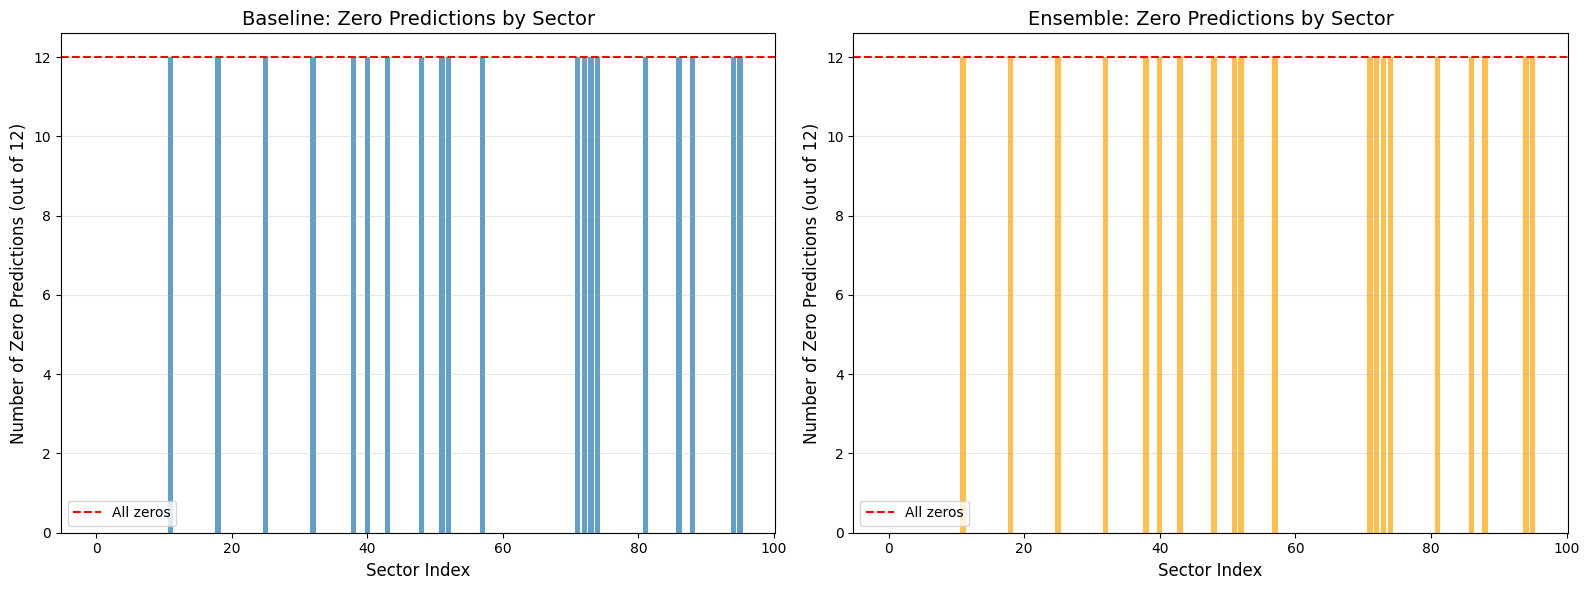

In [ ]:
# =====================================================
# ANALYZE ZERO PREDICTIONS
# =====================================================

def analyze_zero_predictions():
    """Analyze which sectors/months have zero predictions and why."""
    
    # Load submissions
    baseline = pd.read_csv('/Users/nikola/Python/KaggleCompetition/output/EWGM_POI/EWGM_POI_submission_poi.csv')
    ensemble = pd.read_csv('/Users/nikola/Python/KaggleCompetition/output/ENSEMBLE_EWGM/EWGM_ensemble_submission.csv')

    # Load historical data
    month_codes = build_month_codes()
    train, test, poi = load_competition_data_with_poi()
    a_tr, poi_features = build_amount_matrix_with_poi(train, poi, month_codes)
    
    # Parse IDs
    def parse_id(id_str):
        parts = id_str.split('_')
        month = parts[0]
        sector_num = int(parts[1].replace('sector ', ''))
        return month, sector_num
    
    baseline['month'], baseline['sector'] = zip(*baseline['id'].map(parse_id))
    ensemble['month'], ensemble['sector'] = zip(*ensemble['id'].map(parse_id))
    
    # Find zeros
    baseline_zeros = baseline[baseline['new_house_transaction_amount'] == 0]
    ensemble_zeros = ensemble[ensemble['new_house_transaction_amount'] == 0]
    
    print("="*60)
    print("ZERO PREDICTIONS ANALYSIS")
    print("="*60)
    
    print(f"\nBaseline zeros: {len(baseline_zeros)} / {len(baseline)} ({len(baseline_zeros)/len(baseline)*100:.1f}%)")
    print(f"Ensemble zeros: {len(ensemble_zeros)} / {len(ensemble)} ({len(ensemble_zeros)/len(ensemble)*100:.1f}%)")
    
    # Sectors with all zeros
    baseline_zero_sectors = baseline_zeros.groupby('sector').size()
    baseline_all_zero_sectors = baseline_zero_sectors[baseline_zero_sectors == 12].index.tolist()
    
    ensemble_zero_sectors = ensemble_zeros.groupby('sector').size()
    ensemble_all_zero_sectors = ensemble_zero_sectors[ensemble_zero_sectors == 12].index.tolist()
    
    print(f"\nSectors with ALL predictions = 0:")
    print(f"  Baseline: {len(baseline_all_zero_sectors)} sectors: {baseline_all_zero_sectors}")
    print(f"  Ensemble: {len(ensemble_all_zero_sectors)} sectors: {ensemble_all_zero_sectors}")
    
    # Check historical data for these sectors
    print(f"\n{'Sector':<10} {'Historical Sum':<20} {'Historical Mean':<20} {'Non-zero Months':<20}")
    print("-"*70)
    
    all_zero_sectors = set(baseline_all_zero_sectors + ensemble_all_zero_sectors)
    for sector in sorted(all_zero_sectors):
        if sector in a_tr.columns:
            hist_sum = a_tr[sector].sum()
            hist_mean = a_tr[sector].mean()
            nonzero_months = (a_tr[sector] > 0).sum()
            print(f"{sector:<10} {hist_sum:<20.2f} {hist_mean:<20.2f} {nonzero_months:<20}")
        else:
            print(f"{sector:<10} {'NO HISTORICAL DATA':<20}")
    
    # Sectors with SOME zeros
    print(f"\nSectors with SOME zeros (but not all):")
    partial_zero_sectors = baseline_zero_sectors[(baseline_zero_sectors > 0) & (baseline_zero_sectors < 12)]
    
    print(f"\n{'Sector':<10} {'Zero Months (Baseline)':<25} {'Zero Months (Ensemble)':<25}")
    print("-"*70)
    for sector in partial_zero_sectors.index[:10]:  # Show first 10
        baseline_count = baseline_zero_sectors.get(sector, 0)
        ensemble_count = ensemble_zero_sectors.get(sector, 0)
        print(f"{sector:<10} {baseline_count:<25} {ensemble_count:<25}")
    
    # Visualize zeros by sector
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Count zeros per sector
    baseline_zero_counts = baseline.groupby('sector')['new_house_transaction_amount'].apply(lambda x: (x == 0).sum())
    ensemble_zero_counts = ensemble.groupby('sector')['new_house_transaction_amount'].apply(lambda x: (x == 0).sum())
    
    ax1.bar(range(len(baseline_zero_counts)), baseline_zero_counts.values, alpha=0.7)
    ax1.set_xlabel('Sector Index', fontsize=12)
    ax1.set_ylabel('Number of Zero Predictions (out of 12)', fontsize=12)
    ax1.set_title('Baseline: Zero Predictions by Sector', fontsize=14)
    ax1.axhline(y=12, color='r', linestyle='--', label='All zeros')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2.bar(range(len(ensemble_zero_counts)), ensemble_zero_counts.values, alpha=0.7, color='orange')
    ax2.set_xlabel('Sector Index', fontsize=12)
    ax2.set_ylabel('Number of Zero Predictions (out of 12)', fontsize=12)
    ax2.set_title('Ensemble: Zero Predictions by Sector', fontsize=14)
    ax2.axhline(y=12, color='r', linestyle='--', label='All zeros')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_path']}/zero_predictions_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()

# Run analysis
analyze_zero_predictions()